# Quant DCA ETF Strategy 📈
Enhanced with equity curve and performance metrics visualizations.

# ETF Long-Term Buy & Hold Strategy Notebook
This notebook implements the SPY/QQQ DCA strategy with 200-day MA filtering.

In [16]:
import os
print(f"Working directory: {os.getcwd()}")
from utils.data_fetch import get_price_data

Working directory: C:\Users\luyanda\workspace\QuantTrade


## 1. Setup

In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define strategy parameters
START_DATE = "2008-01-01"
END_DATE = "2025-08-01"

ETFS = ["SPY", "QQQ", "SPLV", "SHY"]
ALLOCATION_PER_MONTH = 500  # USD
CORE_ALLOCATION = {"SPY": 0.5, "QQQ": 0.5}
CORE_ALLOCATION_FALLBACK = {"SPLV": 1}
TREND_LOOKBACK = 200  # days for moving average filter

## 2. Data Ingestion

In [ ]:
# TODO adjust funciton to be continuous pull
# # Pull adjusted close prices from local cache or Tiingo API
# daily_data = get_price_data(
#     symbols=ETFS,
#     start=START_DATE,
#     end=END_DATE,
#     ohlcv=False
# )

# # Preview last few rows
# daily_data.tail()

In [26]:
daily_price_dir = "data/raw/tiingo/price"
daily_data = {}

for symbol in ETFS:
    path = os.path.join(daily_price_dir, f"{symbol}.csv")
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    daily_data[symbol] = df.iloc[-200:]  # last 200 days

daily_data["SPY"].tail()

,SPY
date,
2025-06-25 00:00:00+00:00,607.12
2025-06-26 00:00:00+00:00,611.87
2025-06-27 00:00:00+00:00,614.91
2025-06-30 00:00:00+00:00,617.85
2025-07-01 00:00:00+00:00,617.65


In [ ]:
# TODO adjust funciton to be continuous pull
# Ingest 1min data  

minute_data_dir = "data/raw/alpaca/minute"
# symbols = ["SPY", "QQQ", "SPLV", "SHY"]
minute_data = {}

for symbol in ETFS:
    path = os.path.join(minute_data_dir, f"{symbol}_1min.csv")
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    # df = df[df.index.date == df.index[-1].date()]  # today's data only
    last_day = df.index[-1].normalize()
    df = df[df.index.normalize() == last_day]
    minute_data[symbol] = df

# Preview last few rows
minute_data["SPY"].tail()

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2025-08-01 16:43:00+00:00,623.0653,623.135,622.9650,2411,623.050,265218,623.050782
2025-08-01 16:44:00+00:00,623.1500,623.190,623.0499,2226,623.065,196131,623.128968
2025-08-01 16:45:00+00:00,623.5200,623.530,623.0900,2784,623.130,211598,623.255037
2025-08-01 16:46:00+00:00,623.4400,623.665,623.3650,2125,623.510,188143,623.521239
2025-08-01 16:47:00+00:00,623.0300,623.490,623.0300,3177,623.430,243563,623.210432


## 3. Feature Engineering

In [22]:
def compute_features(data, lookback):
    ma = data.rolling(window=lookback).mean()
    ma.columns = [f"{col}_ma" for col in ma.columns]
    signals = (data >= ma.values).astype(int)
    signals.columns = [f"{col}_signal" for col in data.columns]
    return pd.concat([data, ma, signals], axis=1)


## 4. ETFs vs 200MA buy/sell signals 

In [23]:
# # 📍 Annotated ETF price plots with 200-day MA + Buy/Sell signals

# fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
# axs = axs.flatten()

# for i, etf in enumerate(["SPY", "QQQ", "SPLV", "SHY"]):
#     ax = axs[i]
#     prices = price_data[etf]
#     ma_200 = prices.rolling(200).mean()

#     # Crossover signals
#     buy_signals = (prices > ma_200) & (prices.shift(1) <= ma_200.shift(1))
#     sell_signals = (prices < ma_200) & (prices.shift(1) >= ma_200.shift(1))

#     ax.plot(prices, label="Price", color="black", linewidth=1)
#     ax.plot(ma_200, label="200-day MA", color="blue", linestyle="--")

#     ax.plot(prices[buy_signals], 'g^', label="Buy", markersize=6)
#     ax.plot(prices[sell_signals], 'rv', label="Sell", markersize=6)

#     ax.set_title(f"{etf} with 200-day MA and Buy/Sell Signals")
#     ax.legend()
#     ax.grid(True)

# plt.tight_layout()
# plt.show()


In [24]:
summary = []

for symbol in ETFS:
    minute_df = minute_data[symbol]
    daily_df = daily_data[symbol]

    ma_200 = daily_df[symbol].mean()
    latest_price = minute_df['close'].iloc[-1]

    signal = int(latest_price > ma_200)

    summary.append({
        "Symbol": symbol,
        "Latest Price": latest_price,
        "200-day MA": ma_200,
        "Signal (1=Buy)": signal
    })

signal_df = pd.DataFrame(summary)

# 2025-08-01 16:43:00+00:00


## 5. Intraday (1-min) ETF Prices vs 200-day Moving Average

This chart visualizes the **intraday 1-minute price action** of each ETF (SPY, QQQ, SPLV, SHY) relative to its **long-term 200-day moving average (MA)**.

The **200-day MA** serves as a trend-following filter:
- When **price is above** the 200-day MA, the asset is considered to be in a long-term **uptrend**.
- When **price is below** the 200-day MA, it signals a potential **downtrend or weakness**.

This plot helps us **confirm real-time positioning decisions** before executing a DCA buy:

#### ✅ Allocation Rules:
- **If SPY is above its 200-day MA** → Allow contribution to SPY this month.
- **If SPY is below its 200-day MA** → Redirect SPY contribution to SPLV (or SHY).
- **If QQQ is above its 200-day MA** → Allow contribution to QQQ this month.
- **If QQQ is below its 200-day MA** → Redirect QQQ contribution to SPLV (or SHY).
- **If both SPY and QQQ are below their 200-day MAs** → Go fully defensive: allocate entire amount to SPLV or SHY, depending on which is above its MA.

#### 🕒 Why Intraday View?
Markets often gap or trend early in the session. Checking current price against the 200-day MA on a **1-minute basis** just before execution (e.g., around 10:00 AM ET) lets us make precise and **rule-based allocation decisions** on the day of purchase.


In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[f"{sym} - 1min vs 200-day MA" for sym in minute_data.keys()],
    shared_xaxes=False,
    vertical_spacing=0.15
)

subplot_map = {
    'SPY': (1, 1),
    'QQQ': (1, 2),
    'SPLV': (2, 1),
    'SHY': (2, 2)
}

for sym in minute_data:
    row, col = subplot_map[sym]
    df = minute_data[sym]
    ma_200_val = daily_data[sym][sym].mean()

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['close'],
            mode='lines',
            name=f"{sym} Price",
            line=dict(color='deepskyblue'),
            showlegend=False
        ),
        row=row, col=col
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=[ma_200_val] * len(df),
            mode='lines',
            name=f"{sym} 200MA",
            line=dict(color='orange', dash='dash'),
            showlegend=False
        ),
        row=row, col=col
    )

fig.update_layout(
    height=800,
    title_text="Intraday (1-min) ETF Prices vs 200-day Moving Average",
    title_x=0.5,
    showlegend=False,
    template='plotly_dark'
)

fig.show()


## 5. Strategy Logic

Strategy Rules (Execution Logic)
- Invest $500/month:
  - Default split: 50% SPY, 50% QQQ

- 200-day MA Filter (per ETF):
  - If ETF ≥ 200 MA → ✅ buy normally
  - If ETF < 200 MA → 🔁 redirect that portion to SPLV or SHY, with preference to:
    - SPLV if above 200 MA
    - SHY if SPLV also < 200 MA
    - If both < 200 MA → Hold in cash until next month

- Dividends: Reinvest
- No selling of existing holdings for first 6 months

- Quarterly rebalancing of new contributions to maintain target weights

In [71]:
def run_strategy(prices, features, lookback):
    monthly_dates = prices.resample('ME').last().index
    portfolio_value = []
    cash = 0
    holdings = {etf: 0 for etf in ETFS}

    for date in monthly_dates:
        if date not in features.index:
            continue
        prices_today = features.loc[date, ETFS]
        signals_today = features.loc[date, [f"{etf}_signal" for etf in ETFS]]
        monthly_cash = ALLOCATION_PER_MONTH
        for etf in CORE_ALLOCATION:
            weight = CORE_ALLOCATION[etf]
            etf_cash = monthly_cash * weight
            signal = signals_today[f"{etf}_signal"]
            price = prices_today[etf]
            if signal == 1:
                shares = etf_cash / price
                holdings[etf] += shares
            else:
                fallback_etf = "SPLV" if signals_today["SPLV_signal"] == 1 else "SHY" if signals_today["SHY_signal"] == 1 else None
                if fallback_etf:
                    fallback_price = prices_today[fallback_etf]
                    shares = etf_cash / fallback_price
                    holdings[fallback_etf] += shares
                else:
                    cash += etf_cash
        current_value = sum(holdings[etf] * prices_today[etf] for etf in ETFS) + cash
        portfolio_value.append((date, current_value))

    return pd.DataFrame(portfolio_value, columns=["Date", "Portfolio Value"]).set_index("Date")

## 6. Performance Evaluation

In [72]:
def evaluate_performance(portfolio_df):
    portfolio_df['Returns'] = portfolio_df['Portfolio Value'].pct_change()
    start_val = portfolio_df['Portfolio Value'].iloc[0]
    end_val = portfolio_df['Portfolio Value'].iloc[-1]
    n_years = (portfolio_df.index[-1] - portfolio_df.index[0]).days / 365.25
    CAGR = (end_val / start_val) ** (1 / n_years) - 1
    volatility = portfolio_df['Returns'].std() * np.sqrt(12)
    sharpe = CAGR / volatility if volatility != 0 else np.nan
    drawdown = portfolio_df['Portfolio Value'] / portfolio_df['Portfolio Value'].cummax() - 1
    max_drawdown = drawdown.min()

    
    return CAGR, volatility, sharpe, max_drawdown

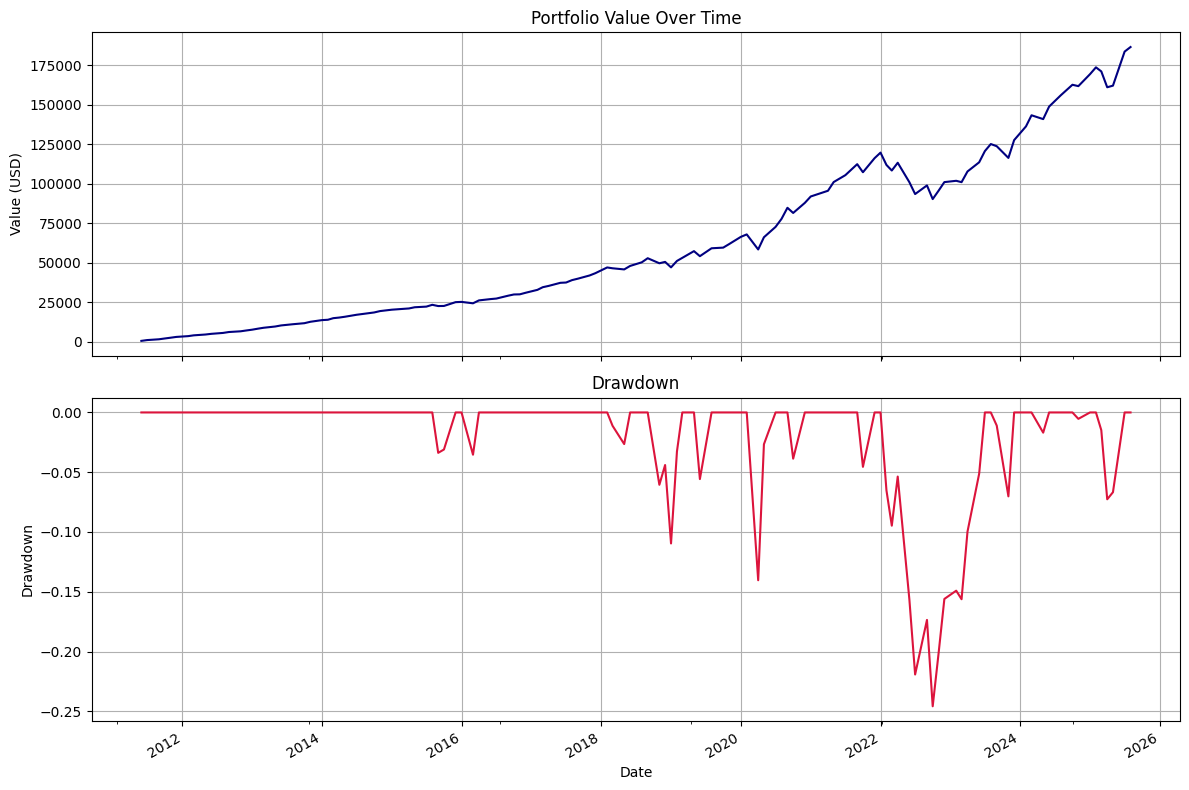

In [73]:
# 📊 Plotting equity curve and drawdown

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Equity curve
portfolio_df['Portfolio Value'].plot(ax=ax[0], title="Portfolio Value Over Time", color='navy')
ax[0].set_ylabel("Value (USD)")
ax[0].grid(True)

# Drawdown
rolling_max = portfolio_df['Portfolio Value'].cummax()
drawdown = portfolio_df['Portfolio Value'] / rolling_max - 1
drawdown.plot(ax=ax[1], color='crimson', title="Drawdown")
ax[1].set_ylabel("Drawdown")
ax[1].grid(True)

plt.tight_layout()
plt.show()


## 7. Sensitivty Analysis

What if the trend filter uses 100, 125, 150, ..., 300 days?

- Is Sharpe ratio peaking around a certain lookback?
- Does max drawdown increase with shorter filters?
- Is there a sweet spot that balances return vs risk?

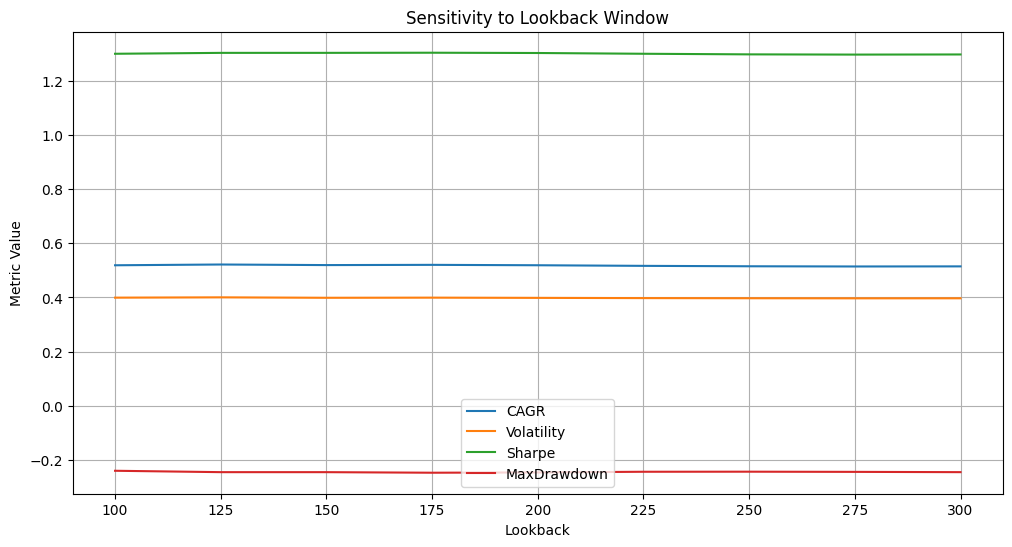

,CAGR,Volatility,Sharpe,MaxDrawdown
Lookback,,,,
100,0.518775,0.399256,1.299355,-0.239627
125,0.521608,0.400413,1.302677,-0.244734
150,0.519462,0.398754,1.302715,-0.244763
175,0.520333,0.399269,1.303217,-0.246835
200,0.518852,0.398450,1.302176,-0.245774
225,0.516617,0.397588,1.299379,-0.243280
250,0.515089,0.397092,1.297154,-0.243024
275,0.514335,0.396768,1.296310,-0.243695
300,0.514698,0.396897,1.296804,-0.244742


In [74]:
lookbacks = range(100, 301, 25)
results = []

for lb in lookbacks:
    features = compute_features(price_data, lb)
    portfolio = run_strategy(price_data, features, lb)
    CAGR, vol, sharpe, mdd = evaluate_performance(portfolio)
    results.append({"Lookback": lb, "CAGR": CAGR, "Volatility": vol, "Sharpe": sharpe, "MaxDrawdown": mdd})

sensitivity_df = pd.DataFrame(results)
sensitivity_df.set_index("Lookback", inplace=True)
sensitivity_df.plot(title="Sensitivity to Lookback Window", figsize=(12, 6), grid=True)
plt.ylabel("Metric Value")
plt.show()

sensitivity_df